# Determining the most favorable tariff for a mobile operator

## Project Description

Mobile operator's customers are offered two tariff plans: Smart and Ultra. To adjust the advertising budget, the commercial department wants to understand which tariff brings in more money.

As part of the study, it is necessary to conduct a preliminary analysis of tariffs on a small sample of customers. We have data on the activity of 500 users for 2018. It is necessary to analyze the behavior of customers and conclude which tariff is better.

As part of the introductory information, there is also a description of 2 tariffs of the company:

**Description of tariffs**

*the "Smart" tariff*
- Monthly fee: 550 rubles
- 500 minutes of conversation, 50 messages and 15 GB of Internet traffic are included 
- The cost of services in excess of the tariff's package: 
    1. Minute of conversation: 3 rubles (Operator always rounds up the values of minutes and megabytes. If the user spoke for only 1 second, the whole minute is counted in the tariff); 
    2. message: 3 rubles; 
    3. 1 GB of Internet traffic: 200 rubles.


*The "Ultra" tariff*
- Monthly fee: 1950 rubles
- 3000 minutes of conversation, 1000 messages and 30 GB of Internet traffic are included
- The cost of services in excess of the tariff's package: 
    1. Minute of conversation: 1 ruble; 
    2. Message: 1 ruble; 
    3. 1 GB of Internet traffic: 150 rubles.

**The purpose of the study**

It is necessary to analyze the behavior of customers and conclude which tariff is more profitable. It is also necessary to answer a number of questions:
- what is the volume of calls made and minutes of conversation spent by month for each user?
- what is the number of messages sent by month for each user?
- what is the amount of Internet traffic consumed by month for each user?
- how much is the monthly revenue from each user?
- how many minutes of conversation, how many messages and how much Internet traffic is required by users of each tariff per month?
- does the average revenue of users of the "Ultra" and "Smart" tariffs differ?
- does the average revenue of users from Moscow differ from the revenue of users from other regions?

**Research plan**

User data is grouped in several files. Nothing is known about the quality of the data. Therefore, before testing hypotheses, we will need to review the data. The data will be checked for errors and their impact on the study will be assessed. Then, at the preprocessing stage, the most critical data errors will be corrected.
Thus, the study will take place in three stages:
- Data overview.
- Data preprocessing.
- Hypothesis testing.

___
## Data overview
___

Let's make a first idea of the data and import all the necessary libraries

In [52]:
import pandas as pd;
import numpy as np;
import seaborn as sns;
import matplotlib.pyplot as plt;
import math
from scipy import stats as st

Let's read the data files from the /datasets folder and save them in variables:

In [53]:
try:
    df_calls = pd.read_csv('/Users/vladislav/Documents/datasets/calls.csv',sep=',')
    df_internet = pd.read_csv('/Users/vladislav/Documents/datasets/internet.csv',sep=',')
    df_messages = pd.read_csv('/Users/vladislav/Documents/datasets/messages.csv',sep=',')
    df_tariffs = pd.read_csv('/Users/vladislav/Documents/datasets/tariffs.csv',sep=',')
    df_users = pd.read_csv('/Users/vladislav/Documents/datasets/users.csv',sep=',')
except:
    df_calls = pd.read_csv('/datasets/calls.csv',sep=',')
    df_internet = pd.read_csv('/datasets/internet.csv',sep=',')
    df_messages = pd.read_csv('/datasets/messages.csv',sep=',')
    df_tariffs = pd.read_csv('/datasets/tariffs.csv',sep=',')
    df_users = pd.read_csv('/datasets/users.csv',sep=',')

According to the terms of the study, the Megaline operator has 2 tariffs in the sample. Their terms are listed below:

In [54]:
#Условия тарифов

#Smart:
S_minutes_limit = 500 #number of minutes included in the package
S_messages_limit = 50 #number of messages included in the package
S_internet_limit = 15 #the amount of traffic included in the package
S_extra_minute = 3 #the cost of a minute over the package, rub.
S_extra_message = 3 #the cost of a message over a package, rub.
S_extra_gb = 200 #the cost of a gigabyte of Internet over a package, rub.
S_monthly_fee = 550 #subscription fee for the tariff

#Ultra
U_minutes_limit = 3000 #number of minutes included in the package
U_messages_limit = 1000 #number of messages included in the package
U_internet_limit = 30 #the amount of traffic included in the package
U_extra_minute = 1 #the cost of a minute over the package, rub.
U_extra_message = 1 #the cost of a message over a package, rub.
U_extra_gb = 150 #the cost of a gigabyte of Internet over a package, rub.
U_monthly_fee = 1950 #subscription fee for the tariff

You can start studying the data from a file with user data *df_users*.

According to the data documentation:
Table *users* (information about users):

* user_id — unique user ID
* first_name — user name
* last_name — last name of the user
* age — user's age (years)
* reg_date — tariff activation date (day, month, year)
* churn_date — date of termination of use of the tariff (if the value is omitted, the tariff was still valid at the time of data upload)
* city — the user's city of residence
* tarif — name of the tariff plan

Since we will need to study a few more files, it is better to write a function describing the dataframe.

In [55]:
def df_describe (df):
    display('First 5 rows', df.head())
    display('Description of numerical data:', df.describe())
    display(df.info())
    display('Number of missing values', df.isna().sum())

In [56]:
df_describe(df_users)

'First 5 rows'

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


'Description of numerical data:'

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

'Number of missing values'

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

It can be noted that there are no missing values in the table except for the column **churn_date**, the values in which indicate the date of termination of the use of the tariff. Missing values, respectively, imply that the tariff was valid at the time of unloading and are not errors.

In [57]:
df_users.groupby(by='user_id')['churn_date'].value_counts()

user_id  churn_date
1019     2018-10-05    1
1020     2018-12-18    1
1034     2018-11-21    1
1050     2018-10-03    1
1051     2018-10-14    1
1056     2018-10-14    1
1062     2018-12-09    1
1063     2018-12-11    1
1064     2018-12-26    1
1065     2018-12-09    1
1071     2018-08-31    1
1090     2018-12-03    1
1128     2018-12-23    1
1161     2018-11-07    1
1163     2018-12-16    1
1191     2018-10-03    1
1201     2018-12-03    1
1206     2018-12-20    1
1232     2018-11-30    1
1242     2018-12-21    1
1254     2018-08-17    1
1255     2018-09-02    1
1265     2018-10-04    1
1271     2018-11-13    1
1293     2018-11-22    1
1343     2018-10-28    1
1353     2018-11-26    1
1355     2018-11-27    1
1367     2018-11-16    1
1370     2018-10-27    1
1371     2018-12-30    1
1392     2018-09-27    1
1399     2018-12-25    1
1416     2018-12-14    1
1422     2018-12-21    1
1438     2018-12-24    1
1480     2018-09-26    1
1498     2018-10-25    1
Name: churn_date, dtype: int64

According to this grouping, it can be seen that 38 values in the **churn_date** column fall on different users, which means that there are no users in the dataframe who would change the tariff more than 1 time inside operator.

There are no values similar to outliers in the age data.

In [58]:
df_users['user_id'].value_counts()

1000    1
1329    1
1342    1
1341    1
1340    1
       ..
1161    1
1160    1
1159    1
1158    1
1499    1
Name: user_id, Length: 500, dtype: int64

You can also see that the data in the **user_id** column is really unique and is not duplicated for different users.

In [59]:
df_users['city'].unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Волжский', 'Курган', 'Барнаул', 'Красноярск', 'Архангельск',
       'Липецк', 'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

There are also no hidden duplicates found by the name of the cities.

In [60]:
pip install pandas --upgrade

Note: you may need to restart the kernel to use updated packages.


In [61]:
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format = '%Y %m %d')
df_users['reg_date'].describe(datetime_is_numeric=True)
df_users['reg_date'].describe()

/var/folders/l7/5cd_m6hn1rl9r89zycsz4t400000gn/T/ipykernel_55241/2820314453.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_users['reg_date'].describe()


count                     500
unique                    270
top       2018-05-28 00:00:00
freq                        8
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: reg_date, dtype: object

In the *reg_date* column, the format has been changed from string to date format for more convenient operation.

In [62]:
df_users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

According to these slices, the registration date has no emissions and omissions and is limited only to 2018. Only correct values are indicated in the data for the selected tariff. Next, we will analyze the file with "calls"
___

In [63]:
df_describe(df_calls)

'First 5 rows'

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


'Description of numerical data:'

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

'Number of missing values'

id           0
call_date    0
duration     0
user_id      0
dtype: int64

According to the data documentation:

Table *calls* (information about calls):

* id — unique call number
* call_date — date of the call
* duration — the duration of the call in minutes
* user_id — ID of the user who made the call

According to the analysis obtained , it can be noted:
- There are no missing values in the dataframe with call data.
- There are also no outliers in terms of the duration of conversations - the longest call lasted 38 minutes, but it is necessary to round the values up to minutes (according to the operator's rules).
- In the description of the *user_id* column data, you can see that the median Id is shifted to 1260 (instead of 1249.5), which means there were subscribers who did not make a single call in a year.
- In the column with the date of the call, you need to change the format for further work with object to datetime.

Let's study the data on the duration of calls and build a histogram.

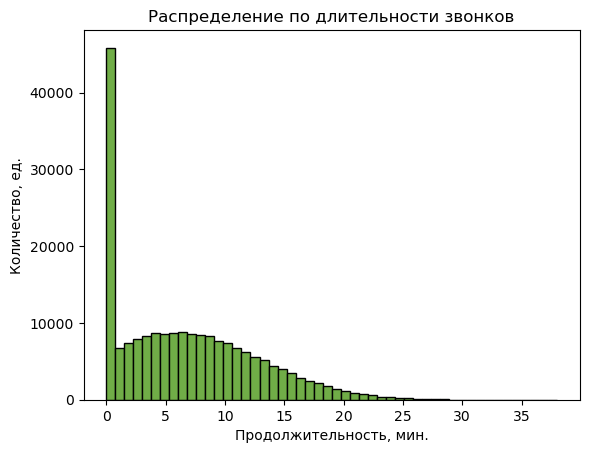

In [64]:
df_calls['duration'].plot(kind='hist',bins=50,  color="#70AD47", edgecolor="black")
plt.title("Распределение по длительности звонков")
plt.xlabel("Продолжительность, мин.")
plt.ylabel("Количество, ед.")
plt.show()

According to this distribution, a peak is visible next to 0 minutes, according to the introductory conditions of the study, it is said that these data are missed calls, not errors.
Otherwise, the distribution does not raise any questions.

In [65]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format = '%Y %m %d')
df_calls['duration'] = df_calls['duration'].apply(np.ceil).astype('int64')
df_calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,7.158198,1253.940619
std,5.959173,144.722751
min,0.000000,1000.000000
25%,2.000000,1126.000000
50%,6.000000,1260.000000
75%,11.000000,1379.000000
max,38.000000,1499.000000


The duration of the call is rounded up to minutes. Next, we will study the data on messages from the dataframe **df_messages**
___

In [66]:
df_describe(df_messages)

'First 5 rows'

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


'Description of numerical data:'

,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

'Number of missing values'

id              0
message_date    0
user_id         0
dtype: int64

According to the data documentation:

Table *messages* (information about messages):
* id — unique message number
* message_date — date of the message
* user_id — ID of the user who sent the message

According to the analysis obtained , it can be noted:
- There are no missing values in the dataframe with message data.
- In the description of the user_id column data, you can see that the median Id is shifted - 1271 (instead of 1249.5), which means there were subscribers who did not send a single message for the year.
- In the column with the date of the message, you need to change the format for further work with object to datetime.

In [67]:
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format = '%Y %m %d')

___
Next, we will study the data on messages from the df_tariffs dataframe

In [68]:
df_describe(df_tariffs)

'First 5 rows'

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


'Description of numerical data:'

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
std,671.751442,10861.160159,1767.766953,989.949494,35.355339,1.414214,1.414214
min,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000
25%,287.500000,19200.000000,1125.000000,900.000000,162.500000,1.500000,1.500000
50%,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
75%,762.500000,26880.000000,2375.000000,1600.000000,187.500000,2.500000,2.500000
max,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


None

'Number of missing values'

messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
tariff_name              0
dtype: int64

There are no missing values and errors in the data in this dataframe. Next, you need to study the data from the **df_internet file**
___

In [69]:
df_describe(df_internet)

'First 5 rows'

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


'Description of numerical data:'

,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


None

'Number of missing values'

Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

Let's study the data on Internet sessions and build a histogram.

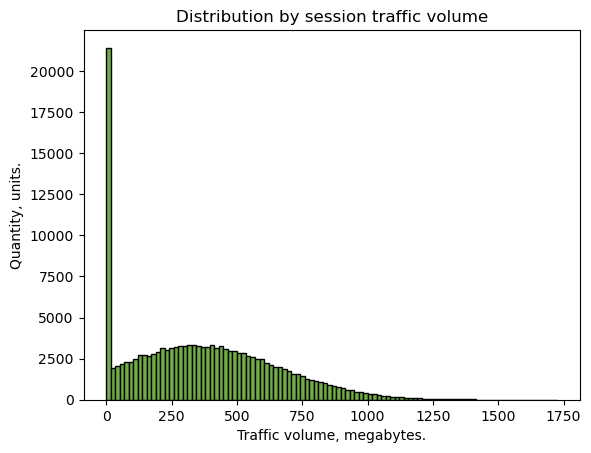

In [70]:
df_internet['mb_used'].plot(kind='hist',bins=100,  color="#70AD47", edgecolor="black")
plt.title("Distribution by session traffic volume")
plt.xlabel("Traffic volume, megabytes.")
plt.ylabel("Quantity, units.")
plt.show()

According to the distribution of traffic, a peak is also visible near the zero mark. By analogy with the zero values in the duration of calls, it can be assumed that this was the activation of a SIM card, or operations with the minimum required amount of traffic (approx. background update of the messenger). In the context of a training project, there is no opportunity to clarify the nature of the appearance of these data.

Since their presence will not affect the study of the dependence of expenses on the amount of traffic spent (the volume will fall within the limit of the prepaid Internet package), you can leave the data.

По аналогии с другими файлами также необходимо изменить формат столбца **session_date** в формат datetime.

In [71]:
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'],format='%Y %m %d')
df_internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


At this stage, you can proceed to data preparation.
___

## Data preparation

According to the objectives of the study, we need to determine:
- what is the volume of calls made and minutes of conversation spent by month for each user?
- what is the number of messages sent by month for each user?
- what is the amount of Internet traffic consumed by month for each user?
- - how much is the monthly revenue from each user?

To answer the questions in the above paragraphs, you will need data broken down by month.

In [72]:
df_calls['date_month'] = pd.DatetimeIndex(df_calls['call_date']).month
df_messages['date_month'] = pd.DatetimeIndex(df_messages['message_date']).month
df_internet['date_month'] = pd.DatetimeIndex(df_internet['session_date']).month
df_messages.head()

,id,message_date,user_id,date_month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


So, there are 3 tables with calls, messages and Internet sessions, but it is impossible to combine them into a single dataframe in the current form, since in the rows of each of the tables there are repetitions with similar values **user_id** and **date_month**, since subscribers made more than 1 call (message etc.) for a month. So, the data must first be grouped.

In [73]:
calls_grouped = df_calls.groupby(['user_id','date_month'])['duration'].agg(['count','sum']).reset_index()
calls_grouped.columns = ['user_id','date_month','calls_per_month','calls_dur_per_month']
calls_grouped

,user_id,date_month,calls_per_month,calls_dur_per_month
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466
...,...,...,...,...
3169,1498,10,41,247
3170,1499,9,9,70
3171,1499,10,68,449
3172,1499,11,74,612


In [74]:
messages_grouped = df_messages.groupby(['user_id','date_month'])['id'].agg('count').reset_index()
messages_grouped.columns = ['user_id','date_month','messages_per_month']
messages_grouped

,user_id,date_month,messages_per_month
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


In [75]:
internet_grouped = df_internet.groupby(['user_id','date_month'])['mb_used'].agg('sum').reset_index()
internet_grouped['mb_used'] = (internet_grouped['mb_used']/1024).apply(np.ceil).astype('int64')
internet_grouped.columns = ['user_id','date_month','gb_per_month']
internet_grouped

,user_id,date_month,gb_per_month
0,1000,5,3
1,1000,6,23
2,1000,7,14
3,1000,8,14
4,1000,9,15
...,...,...,...
3198,1498,10,21
3199,1499,9,2
3200,1499,10,18
3201,1499,11,18


Now the data is grouped properly and ready to be merged. The join must be carried out on the columns with the unique **id** of the subscriber and the number of the month in which the action was performed. In the **how** parameter, it is better to specify *outer*, since one of the subscribers might not use a certain type of service, and such lines may be lost when combined if a different value is specified.

In [76]:
merged = pd.merge(calls_grouped,messages_grouped, on=['user_id','date_month'], how='outer')
merged

,user_id,date_month,calls_per_month,calls_dur_per_month,messages_per_month
0,1000,5,22.0,159.0,22.0
1,1000,6,43.0,172.0,60.0
2,1000,7,47.0,340.0,75.0
3,1000,8,52.0,408.0,81.0
4,1000,9,58.0,466.0,57.0
...,...,...,...,...,...
3208,1489,8,NaN,NaN,17.0
3209,1489,9,NaN,NaN,32.0
3210,1489,10,NaN,NaN,21.0
3211,1489,11,NaN,NaN,20.0


In [77]:
merged = pd.merge(merged,internet_grouped, on=['user_id','date_month'], how='outer')
merged

,user_id,date_month,calls_per_month,calls_dur_per_month,messages_per_month,gb_per_month
0,1000,5,22.0,159.0,22.0,3.0
1,1000,6,43.0,172.0,60.0,23.0
2,1000,7,47.0,340.0,75.0,14.0
3,1000,8,52.0,408.0,81.0,14.0
4,1000,9,58.0,466.0,57.0,15.0
...,...,...,...,...,...,...
3209,1489,9,NaN,NaN,32.0,17.0
3210,1489,10,NaN,NaN,21.0,20.0
3211,1489,11,NaN,NaN,20.0,18.0
3212,1489,12,NaN,NaN,35.0,17.0


In [78]:
df_users.groupby('user_id')['tariff'].value_counts().max()

1

The maximum value for the number of available tariffs for each subscriber is 1, which means that there were no subscribers in this sample who changed the "ultra" tariff to "smart" or vice versa.

Now let's add a column with the name of the tariff for each subscriber.

In [79]:
tariffs_and_city_grouped = df_users.groupby('user_id')['city','tariff'].first().reset_index()
tariffs_and_city_grouped = pd.DataFrame(tariffs_and_city_grouped)
tariffs_and_city_grouped

/var/folders/l7/5cd_m6hn1rl9r89zycsz4t400000gn/T/ipykernel_55241/2641364452.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tariffs_and_city_grouped = df_users.groupby('user_id')['city','tariff'].first().reset_index()


,user_id,city,tariff
0,1000,Краснодар,ultra
1,1001,Москва,smart
2,1002,Стерлитамак,smart
3,1003,Москва,ultra
4,1004,Новокузнецк,ultra
...,...,...,...
495,1495,Иркутск,ultra
496,1496,Вологда,smart
497,1497,Челябинск,smart
498,1498,Владикавказ,smart


In [80]:
merged = pd.merge(merged,tariffs_and_city_grouped, on=['user_id'], how='outer')
merged.head(15)

,user_id,date_month,calls_per_month,calls_dur_per_month,messages_per_month,gb_per_month,city,tariff
0,1000,5.0,22.0,159.0,22.0,3.0,Краснодар,ultra
1,1000,6.0,43.0,172.0,60.0,23.0,Краснодар,ultra
2,1000,7.0,47.0,340.0,75.0,14.0,Краснодар,ultra
3,1000,8.0,52.0,408.0,81.0,14.0,Краснодар,ultra
4,1000,9.0,58.0,466.0,57.0,15.0,Краснодар,ultra
5,1000,10.0,57.0,350.0,73.0,15.0,Краснодар,ultra
6,1000,11.0,43.0,338.0,58.0,15.0,Краснодар,ultra
7,1000,12.0,46.0,333.0,70.0,10.0,Краснодар,ultra
8,1001,11.0,59.0,430.0,NaN,18.0,Москва,smart
9,1001,12.0,63.0,414.0,NaN,14.0,Москва,smart


Now, based on the received summary data with spending limits by month, it is possible to calculate monthly revenue from each user. To do this, we will write a function using the conditions of the tariffs given at the beginning of the study.

In [81]:
def revenue (calls_dur_per_month, messages_per_month, gb_per_month, tariff):

    calls_overrun = 0
    messages_overrun = 0
    internet_overrun = 0
    
    if tariff == 'smart':
        
        if (calls_dur_per_month - S_minutes_limit) > 0:
            calls_overrun = (calls_dur_per_month - S_minutes_limit)* S_extra_minute
        if (messages_per_month - S_messages_limit) > 0:
            messages_overrun = (messages_per_month - S_messages_limit) * S_extra_message
        if (gb_per_month - S_internet_limit) > 0:
            internet_overrun = (gb_per_month - S_internet_limit) * S_extra_gb
            
        return calls_overrun + messages_overrun + internet_overrun + S_monthly_fee

    if tariff == 'ultra':
        
        if (calls_dur_per_month - U_minutes_limit) > 0:
            calls_overrun = (calls_dur_per_month - U_minutes_limit)* U_extra_minute
        if (messages_per_month - U_messages_limit) > 0:
            messages_overrun = (messages_per_month - U_messages_limit) * U_extra_message
        if (gb_per_month - U_internet_limit) > 0:
            internet_overrun = (gb_per_month - U_internet_limit) * U_extra_gb
            
        return calls_overrun + messages_overrun + internet_overrun + U_monthly_fee

In [82]:
merged['revenue'] = (merged.apply(lambda x: revenue (
    x.calls_dur_per_month, x.messages_per_month, x.gb_per_month, x.tariff),axis=1))

Let's check how the function worked.

In [83]:
merged.query('tariff == "smart" and calls_dur_per_month > 500').head()

,user_id,date_month,calls_per_month,calls_dur_per_month,messages_per_month,gb_per_month,city,tariff,revenue
32,1005,3.0,77.0,606.0,56.0,11.0,Набережные Челны,smart,886.0
33,1005,4.0,101.0,712.0,41.0,10.0,Набережные Челны,smart,1186.0
34,1005,5.0,73.0,595.0,42.0,8.0,Набережные Челны,smart,835.0
35,1005,6.0,80.0,612.0,47.0,10.0,Набережные Челны,smart,886.0
36,1005,7.0,77.0,569.0,56.0,8.0,Набережные Челны,smart,775.0


In [84]:
merged.query('tariff == "ultra" and gb_per_month > 30').head()

,user_id,date_month,calls_per_month,calls_dur_per_month,messages_per_month,gb_per_month,city,tariff,revenue
159,1024,11.0,157.0,1146.0,NaN,43.0,Санкт-Петербург,ultra,3900.0
160,1024,12.0,136.0,949.0,NaN,36.0,Санкт-Петербург,ultra,2850.0
311,1050,7.0,35.0,209.0,52.0,35.0,Тюмень,ultra,2700.0
383,1060,12.0,184.0,1233.0,52.0,43.0,Калуга,ultra,3900.0
782,1124,10.0,152.0,1225.0,121.0,49.0,Махачкала,ultra,4800.0


The profit received in the **revenue** column corresponds to the conditions of the operator's tariffs. The function worked correctly. At the same time, if the subscriber did not use any type of services (example: did not send messages) the column indicates Nan. It is better to replace them with zero values.

In [85]:
merged = merged.fillna(0)

Next, we need to calculate how many minutes, messages and Internet traffic each user needed on average. We use the median value for these purposes. 

In [86]:
median_per_user = merged.pivot_table(
    index='user_id', values=['calls_dur_per_month','messages_per_month','gb_per_month','revenue'], aggfunc='median')
median_per_user = pd.merge(median_per_user,tariffs_and_city_grouped, on=['user_id'], how='outer')
median_per_user.head()

,user_id,calls_dur_per_month,gb_per_month,messages_per_month,revenue,city,tariff
0,1000,339.0,14.5,65.0,1950.0,Краснодар,ultra
1,1001,422.0,16.0,0.0,850.0,Москва,smart
2,1002,214.0,18.0,11.0,1150.0,Стерлитамак,smart
3,1003,824.0,12.0,83.0,1950.0,Москва,ultra
4,1004,132.5,18.0,154.5,1950.0,Новокузнецк,ultra


At this stage, you can proceed to data analysis.
___

## Data analysis

In [87]:
median_per_user.pivot_table(
    index='tariff', 
    values=['calls_dur_per_month', 'messages_per_month', 'gb_per_month'],
    aggfunc=['mean','median','var','std']).T.unstack()

tariff               smart                                  \
       calls_dur_per_month gb_per_month messages_per_month   
mean            436.222222    16.878917          33.673789   
median          439.500000    17.000000          28.500000   
var           26157.241905    17.337440         785.603997   
std             161.732006     4.163825          28.028628   

tariff               ultra                                  
       calls_dur_per_month gb_per_month messages_per_month  
mean            553.761745    20.181208          56.600671  
median          533.500000    20.000000          47.500000  
var           93752.964810    78.098699        2429.675608  
std             306.191059     8.837347          49.291740

* It is noteworthy that the average **"Ultra"** tariff users  talked only 118 minutes longer than the tariff users **"Smart"**, despite the fact that their limits differ by 6 times.

* The median values of the duration of conversations are close to the average in both tariffs.

* The duration of the conversation, the volume of traffic and the number of messages sent have a large variance according to the "Ultra" tariff.

* In terms of the average amount of Internet traffic consumed, there is also a slight difference between the tariffs (17 GB and 20 GB in Smart and Ultra respectively, despite the fact that the limits also differ significantly in favor of a more expensive tariff).

* In terms of the volume of messages sent in absolute terms, the difference is also minimal between the tariffs, but in relative terms it turns out that users of the smart tariff use about 2/3 of their limit, while users of the Ultra tariff use about 6% of the total prepaid volume. Obviously, for the "Ultra" tariff, the package for 1000 messages carries more of a marketing function, but in fact is practically not used by subscribers.

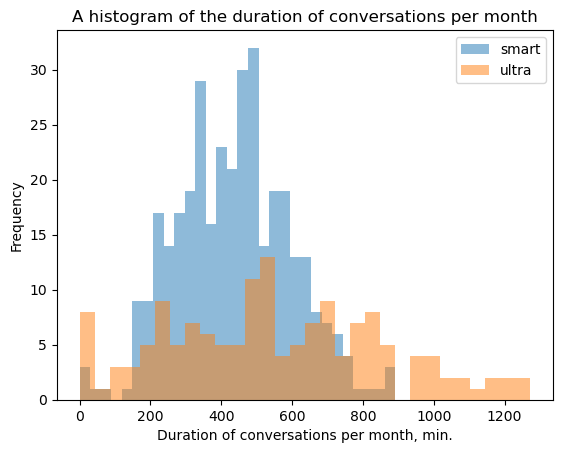

In [88]:
for tariff in ['smart','ultra']:
    median_per_user.query('tariff == @tariff')['calls_dur_per_month'].plot(kind='hist', alpha = 0.5, bins=30)
    plt.legend(['smart','ultra'])
    plt.title("A histogram of the duration of conversations per month")
    plt.ylabel("Frequency")
    plt.xlabel("Duration of conversations per month, min.")
    plt.show

According to the histogram of the duration of conversations per month, it is possible to note peaks in the range of 300-500 minutes for Smart subscribers, the distribution of the duration of conversations of subscribers of the Ultra tariff is more uniform, also with a small peak around 500 minutes.

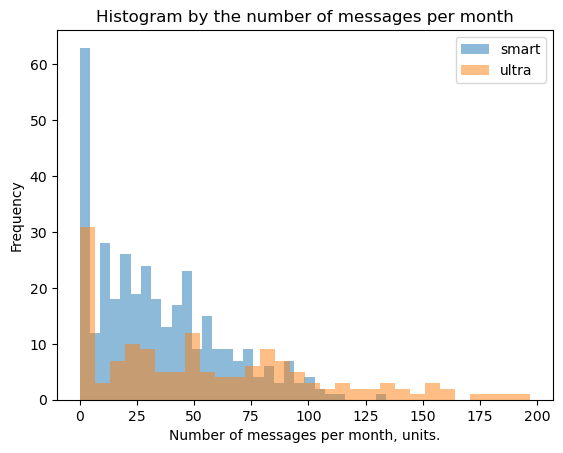

In [89]:
for tariff in ['smart','ultra']:
    median_per_user.query('tariff == @tariff')['messages_per_month'].plot(kind='hist', alpha = 0.5, bins=30)
    plt.legend(['smart','ultra'])
    plt.title("Histogram by the number of messages per month")
    plt.ylabel("Frequency")
    plt.xlabel("Number of messages per month, units.")
    plt.show

The histogram of the number of messages per month shows notable peak around zero, which means that a significant part of subscribers of both tariffs do not use messages. On average, users of the Smart tariff still sent messages more often than subscribers of the more expensive tariff (including exceeding the limit of prepaid messages).

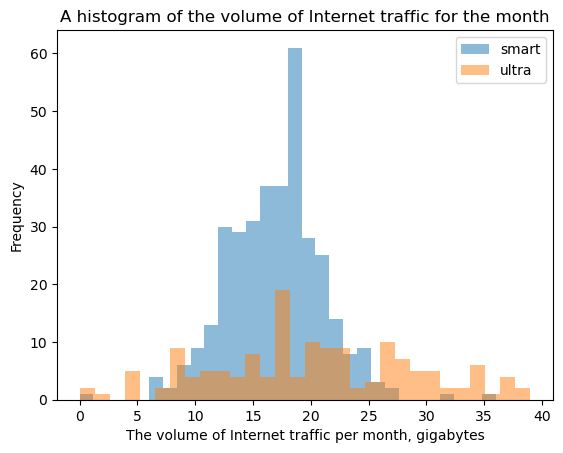

In [90]:
for tariff in ['smart','ultra']:
    median_per_user.query('tariff == @tariff')['gb_per_month'].plot(kind='hist', alpha = 0.5, bins=30)
    plt.legend(['smart','ultra'])
    plt.title("A histogram of the volume of Internet traffic for the month")
    plt.ylabel("Frequency")
    plt.xlabel("The volume of Internet traffic per month, gigabytes")
    plt.show

По гистограмме объема использованного интернет трафика по обоим тарифам заметно пиковое значение в районе 17-19 гб/мес. По данным абонентов тарифа "Смарт" видно, что они чаще выходят за пределы пакета в рамках своего тарифа.

<function matplotlib.pyplot.show(close=None, block=None)>

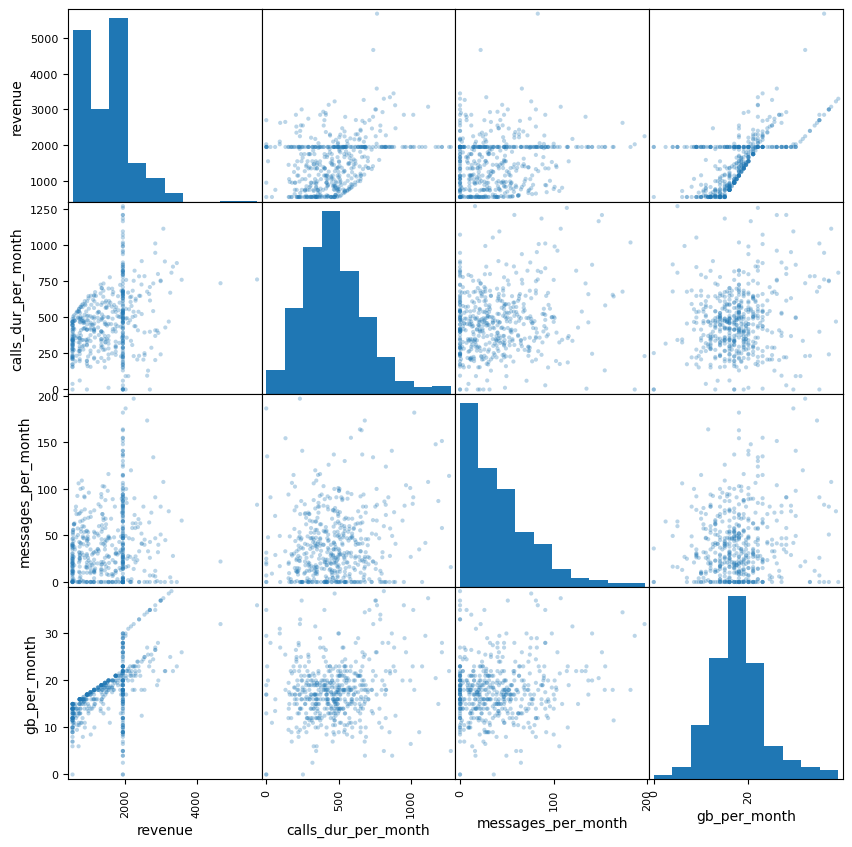

In [91]:
pd.plotting.scatter_matrix(
    median_per_user[['revenue','calls_dur_per_month', 'messages_per_month', 'gb_per_month']], alpha = 0.3, figsize = (10,10))
plt.show

According to the scattering matrix, we can observe the relationship between revenue and the duration of conversations, as well as between revenue and the amount of Internet traffic consumed. At the same time, the Pearson correlation coefficient between the duration of the conversation and revenue shows a weak relationship.

In [92]:
median_per_user['revenue'].corr(median_per_user['calls_dur_per_month'])

0.33353615993895197

At the same time, the correlation between the volume of Internet traffic and revenue is much stronger.

In [93]:
median_per_user['revenue'].corr(median_per_user['gb_per_month'])

0.6285115579814572

The next step is to test the hypotheses
___

## Hypothesis testing

**Null hypothesis** - the average revenue of users of the "Ultra" and "Smart" tariffs are equal

**Alternative hypothesis** - the average revenue of users of the "Ultra" and "Smart" tariffs are not equal

alpha = 5%

Before conducting a statistical test, we will conduct a Barlett test to determine whether the sample variances are equal.

In [94]:
from scipy.stats import bartlett
ultra = merged.query('tariff == "ultra"')['revenue']
smart = merged.query('tariff == "smart"')['revenue']
stat, p = bartlett(ultra, smart)
p

1.0829918779018596e-141

Since the p-value is less than 5%, when calculating the statistical test, it can be indicated that the sample variances are not equal.

In [95]:
alpha = .05

results = st.ttest_ind(
    ultra, 
    smart, 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("We reject the null hypothesis")
else:
    print("It was not possible to reject the null hypothesis")

p-значение: 1.927011394420941e-250
We reject the null hypothesis


In [96]:
display(ultra.median())
display(smart.median())

1950.0

1021.0

With 99% confidence that the average revenue from the "Ultra" tariff really differs from the average revenue from the "Smart" tariff.

Despite the fact that initially the cost of tariffs differs almost 4 times (550 rubles and 1950 rubles). In fact, on average, the revenue rates differ only 2 times. Since subscribers of the "Smart" tariff, due to the lack of a package of minutes and Internet traffic, pay extra for the actual overspending.

**Null hypothesis** - the average revenue of users from Moscow is equal to the average revenue of users from other regions

**Alternative hypothesis** - the average revenue of users from Moscow differs from the revenue of users from other regions

alpha = 5%

Before conducting a statistical test, we will conduct a Barlett test to determine whether the sample variances are equal.

In [97]:
Moscow = merged.query('city == "Москва"')['revenue']
regions = merged.query('city != "Москва"')['revenue']
stat, p = bartlett(Moscow, regions)
p

0.02454560808639366

Since the p-value is also less than 5%, when calculating the statistical test, it can be indicated that the sample variances are not equal.

In [98]:
alpha = .05

results = st.ttest_ind(
    Moscow, 
    regions, 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("We reject the null hypothesis")
else:
    print("It was not possible to reject the null hypothesis")

p-значение: 0.5216952110000279
It was not possible to reject the null hypothesis


In [99]:
display(Moscow.median())
display(regions.median())

1750.0

1583.0

According to the results of this statistical test, it was not possible to refute the hypothesis that revenue from customers in Moscow and other cities are equal. The median values for the sample are also very close.
If the hypothesis had been rejected with a probability of 52%, this decision could have been erroneous.

## Conclusion

According to the results of statistical tests, it can be argued that with a probability of 99%, the average revenue from the "Ultra" tariff differs from the average revenue from the "Smart" tariff.
Also, according to the results of statistical tests, it was not possible to reject the hypothesis that revenue in Moscow and other cities is equal.

Additionally, within the framework of the study , it was established:
* On average, users of the Smart tariff pay almost 2 times more than the fixed subscription fee of 1021 rubles (instead of 550 rubles).
* The overpayment is due to the lack of a package of services provided under the tariff - in particular, in terms of minutes (about a third of subscribers (33%) do not fit into the 500-minute package), as well as in terms of Internet traffic (only 30% of users fit into the 15 GB package)
* Users of the "Ultra" tariff, on the contrary, rarely go beyond the prepaid package of services, as a result of which the revenue from these users on average does not exceed the subscription fee - 1950 rubles.
* On average, users of the "Ultra" tariff spent no more than 534 minutes on conversations, and no more than 20 gigabytes on the Internet.
* A significant part of subscribers of both tariffs do not use messages.